In [1]:
import numpy as np
import pycuda.driver as cuda

In [2]:
import cv2

In [7]:
import numpy as np
import cv2
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt

def rgb2grey_cpu(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)

image = cv2.imread("./lena.png")
im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mod = SourceModule \
    (
"""                                                                                                                                                                              
                                                                                                                                                                                                                                                                                                                                                      
__global__
void colorConvertToGrey(unsigned char *rgb, unsigned char *grey, int rows, int cols)
{
    int col = threadIdx.x + blockIdx.x * blockDim.x;
    int row = threadIdx.y + blockIdx.y * blockDim.y;
    if (col < cols && row < rows)
    {
        int grey_offset = row * cols + col;
        int rgb_offset = grey_offset * 3;
        unsigned char r = rgb[rgb_offset + 0];
        unsigned char g = rgb[rgb_offset + 1];
        unsigned char b = rgb[rgb_offset + 2];
        grey[grey_offset] = r * 0.299f + g * 0.587f + b * 0.114f; 
    }
}                                                                                                                                                                                      
                                                                                                                                                                                         
"""
)

rows = 512
cols = 512
#a = np.random.randint(0, 256, (rows, cols, 3), dtype=np.uint8)

grey = np.zeros((rows, cols)).astype(np.uint8)
colorConvertToGrey = mod.get_function("colorConvertToGrey")
colorConvertToGrey(drv.In(im_rgb), drv.Out(grey), np.intc(rows), np.intc(cols), block=(16, 16, 1), grid=(32,32,1))
np.array_equal(rgb2grey_cpu(im_rgb), grey)

False

In [8]:
rgb2grey_cpu(im_rgb)

array([[162, 162, 162, ..., 169, 154, 128],
       [162, 162, 162, ..., 169, 154, 128],
       [162, 162, 162, ..., 169, 154, 128],
       ...,
       [ 42,  42,  49, ..., 104, 100,  98],
       [ 43,  43,  54, ..., 103, 105, 107],
       [ 43,  43,  54, ..., 103, 105, 107]], dtype=uint8)

In [9]:
res = (rgb2grey_cpu(im_rgb) == grey)

In [10]:
res

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [11]:
np.where(res == False)[0]

array([  0,   1,   2,   3,   4,   5,   5,  13,  17,  28,  35,  36,  39,
        40,  41,  41,  42,  47,  53,  53,  54,  75,  79,  79,  88,  96,
        98, 105, 115, 117, 122, 129, 142, 167, 180, 185, 203, 209, 211,
       212, 218, 219, 229, 230, 230, 231, 234, 235, 236, 243, 254, 254,
       267, 269, 284, 285, 287, 289, 295, 298, 298, 304, 310, 321, 328,
       332, 335, 343, 345, 348, 349, 361, 395, 407, 426, 429, 440, 441,
       449, 452, 455, 463, 463, 464, 469, 469, 470, 475, 485, 510, 510,
       511, 511])

In [12]:
np.where(res == False)[1]

array([ 31,  31,  31,  31,  31, 345, 400, 383, 185, 384,   5, 412, 356,
       376, 128, 235, 226, 367,  49, 171, 466, 489, 255, 445, 439,  39,
       259,  44, 270, 272, 127, 416, 222, 350,  66, 314, 229, 185, 267,
       248, 418, 233,  56, 208, 281, 217, 411,  36, 213, 121,  36, 209,
       135,  62,  63, 480,  23,  37, 134, 151, 449, 104, 364, 184, 197,
       471,  57, 217,  73, 299, 332, 505, 383, 430,   4,  74, 432, 222,
        72, 262, 456, 221, 261, 391, 259, 437, 226, 103, 427, 173, 272,
       173, 272])

In [13]:
x = im_rgb[0][31]

In [14]:
x

array([223, 131, 109], dtype=uint8)

In [15]:
x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114

155.99999999999997

In [16]:
rgb2grey_cpu(im_rgb)[0][31]

155

In [17]:
grey[0][31]

156

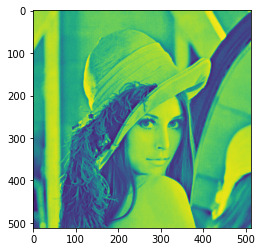

In [112]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import scipy.misc as scm
import matplotlib.pyplot as p

mod = SourceModule \
    (
        """
#include<stdio.h>
#define INDEX(a, b) a*512+b

__global__ void standardize(float *dest_r, float *dest_g, float *dest_b, float *r_img, float *g_img, float *b_img)
{

unsigned int idx = threadIdx.x+(blockIdx.x*(blockDim.x*blockDim.y));

  unsigned int a = idx/512;
  unsigned int b = idx%512;

dest_r[INDEX(a, b)] = ((r_img[INDEX(a, b)]/255 - 0.485)) / 0.229;
dest_g[INDEX(a, b)] = ((g_img[INDEX(a, b)]/255 - 0.456)) / 0.224;
dest_b[INDEX(a, b)] = ((b_img[INDEX(a, b)]/255 - 0.406)) / 0.225;


}

""")
a = cv2.imread('./lena.png').astype(np.float32)
r_img = a[:, :, 0].reshape(262144, order='F')
g_img = a[:, :, 1].reshape(262144, order='F')
b_img = a[:, :, 2].reshape(262144, order='F')
dest_r=r_img
dest_g=g_img
dest_b=b_img
standardize = mod.get_function("standardize")
standardize(drv.Out(dest_r), drv.Out(dest_g), drv.Out(dest_b), drv.In(r_img), drv.In(g_img),drv.In(b_img),block=(1024, 1, 1), grid=(256, 1, 1))

dest_r=np.reshape(dest_r,(512,512), order='F')
dest_b=np.reshape(dest_b,(512,512), order='F')
p.imshow(dest_b)
p.show()

In [115]:
image = cv2.imread("./lena.png")
res_cpu = standardize_cpu(image)
dest_r=np.reshape(dest_r,(512,512), order='F')
print(np.allclose(dest_r, res_cpu[:,:,0]))
dest_g=np.reshape(dest_g,(512,512), order='F')
print(np.allclose(dest_g, res_cpu[:,:,1]))
dest_b=np.reshape(dest_b,(512,512), order='F')
print(np.allclose(dest_b, res_cpu[:,:,2]))

True
True
True


In [118]:
res_cpu = res_cpu.transpose((2, 0, 1)).ravel()

In [120]:
image = np.concatenate((dest_r, dest_g, dest_b), axis=None)

In [119]:
res_cpu.shape

(786432,)

In [121]:
image.shape

(786432,)

In [122]:
np.allclose(res_cpu, image)

True

In [22]:
%timeit -n 100 standardize(drv.Out(dest_r), drv.Out(dest_g), drv.Out(dest_b), drv.In(r_img), drv.In(g_img),drv.In(b_img),block=(1024, 1, 1), grid=(256, 1, 1))

2.4 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit -n 100 standardize_cpu(image)

10.8 ms ± 69.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
image = a

In [116]:
dest = np.concatenate((dest_r, dest_g, dest_b), axis=None)

In [117]:
dest.shape

(786432,)

In [95]:
dest_r

array([[ 0.0226903 ,  0.0226903 ,  0.15968846, ..., -0.02868396,
        -0.23418099, -0.5766761 ],
       [ 0.0226903 ,  0.0226903 ,  0.15968846, ..., -0.02868396,
        -0.23418099, -0.5766761 ],
       [ 0.0226903 ,  0.0226903 ,  0.15968846, ..., -0.02868396,
        -0.23418099, -0.5766761 ],
       ...,
       [-1.0904187 , -1.0904187 , -1.1246682 , ..., -0.6794246 ,
        -0.8164226 , -0.7650483 ],
       [-1.141793  , -1.141793  , -1.0561692 , ..., -0.7650483 ,
        -0.73079884, -0.73079884],
       [-1.141793  , -1.141793  , -1.0561692 , ..., -0.7650483 ,
        -0.73079884, -0.73079884]], dtype=float32)

In [32]:
res[:,:,0].shape

(512, 512)

In [33]:
dest_r.shape

(512, 512)

True

In [97]:
dest_g=np.reshape(dest_g,(512,512), order='F')
np.allclose(dest_g, res[:,:,1])

True

False

In [40]:
dest_b.shape

(512, 512)

In [46]:
dest_b

array([[ 2.1345534 ,  2.1345534 ,  2.0822659 , ...,  2.2042701 ,
         2.0474074 ,  1.6813943 ],
       [ 2.1345534 ,  2.1345534 ,  2.0822659 , ...,  2.2042701 ,
         2.0474074 ,  1.6813943 ],
       [ 2.1345534 ,  2.1345534 ,  2.0822659 , ...,  2.2042701 ,
         2.0474074 ,  1.6813943 ],
       ...,
       [-0.3403921 , -0.3403921 , -0.20095856, ...,  1.2108061 ,
         1.193377  ,  1.280523  ],
       [-0.3752505 , -0.3752505 , -0.1312418 , ...,  1.3153813 ,
         1.3502398 ,  1.4199564 ],
       [-0.3752505 , -0.3752505 , -0.1312418 , ...,  1.3153813 ,
         1.3502398 ,  1.4199564 ]], dtype=float32)

In [42]:
res[:,:,1]

array([[ 0.3627451 ,  0.3627451 ,  0.3627451 , ...,  0.55532213,
         0.24019608, -0.30252101],
       [ 0.3627451 ,  0.3627451 ,  0.3627451 , ...,  0.55532213,
         0.24019608, -0.30252101],
       [ 0.3627451 ,  0.3627451 ,  0.3627451 , ...,  0.55532213,
         0.24019608, -0.30252101],
       ...,
       [-1.72058824, -1.72058824, -1.56302521, ..., -0.75770308,
        -0.8452381 , -0.95028011],
       [-1.65056022, -1.65056022, -1.4754902 , ..., -0.81022409,
        -0.79271709, -0.74019608],
       [-1.65056022, -1.65056022, -1.4754902 , ..., -0.81022409,
        -0.79271709, -0.74019608]])

In [47]:
b_img

array([2.1345534, 2.1345534, 2.1345534, ..., 1.280523 , 1.4199564,
       1.4199564], dtype=float32)

In [48]:
a = cv2.imread('./lena.png').astype(np.float32)
r_img = a[:, :, 0].reshape(262144, order='F')
g_img = a[:, :, 1].reshape(262144, order='F')
b_img = a[:, :, 2].reshape(262144, order='F')

In [49]:
b_img

array([226., 226., 226., ..., 177., 185., 185.], dtype=float32)

In [51]:
r_img

array([125., 125., 125., ...,  79.,  81.,  81.], dtype=float32)

[0. 0. 0. ... 0. 0. 0.]


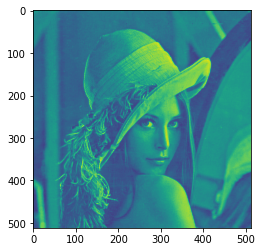

In [82]:
import numpy as np
import scipy.misc as scm
import matplotlib.pyplot as p

mod = SourceModule \
    (
        """
#include<stdio.h>
#define INDEX(a, b) a*512+b

__global__ void standardize(float *dest_r, float *r_img)
{

unsigned int idx = threadIdx.x+(blockIdx.x*(blockDim.x*blockDim.y));

  unsigned int a = idx/512;
  unsigned int b = idx%512;
  dest_r[INDEX(a, b)] = ((r_img[INDEX(a, b)]/255 - 0.485)) / 0.229;
  //dest_r[INDEX(a, b)] = ((r_img[INDEX(a, b)]/255 - 0.406)) / 0.225;
}

""")
a = cv2.imread('./lena.png').astype(np.float32)
r_img = a[:, :, 0].reshape(262144, order='F')
g_img = a[:, :, 1].reshape(262144, order='F')
b_img = a[:, :, 2].reshape(262144, order='F')
dest_r=r_img
dest_g=g_img
dest_b=np.zeros_like(b_img)
print(dest_b)
standardize = mod.get_function("standardize")
standardize(drv.Out(dest_r), drv.In(r_img),block=(1024, 1, 1), grid=(256, 1, 1))

dest_r=np.reshape(dest_r,(512,512), order='F')
dest_b=np.reshape(dest_b,(512,512), order='F')
p.imshow(dest_r)
p.show()

In [83]:
np.allclose(dest_r, res[:,:,0])

True

In [76]:
dest_r

array([[ 0.37420478,  0.37420478,  0.5136385 , ...,  0.3219172 ,
         0.1127669 , -0.23581696],
       [ 0.37420478,  0.37420478,  0.5136385 , ...,  0.3219172 ,
         0.1127669 , -0.23581696],
       [ 0.37420478,  0.37420478,  0.5136385 , ...,  0.3219172 ,
         0.1127669 , -0.23581696],
       ...,
       [-0.7586928 , -0.7586928 , -0.7935512 , ..., -0.3403921 ,
        -0.47982565, -0.42753807],
       [-0.8109804 , -0.8109804 , -0.7238344 , ..., -0.42753807,
        -0.3926797 , -0.3926797 ],
       [-0.8109804 , -0.8109804 , -0.7238344 , ..., -0.42753807,
        -0.3926797 , -0.3926797 ]], dtype=float32)

In [77]:
res[:,:,0]

array([[ 0.0226903 ,  0.0226903 ,  0.15968833, ..., -0.02868396,
        -0.23418101, -0.57667609],
       [ 0.0226903 ,  0.0226903 ,  0.15968833, ..., -0.02868396,
        -0.23418101, -0.57667609],
       [ 0.0226903 ,  0.0226903 ,  0.15968833, ..., -0.02868396,
        -0.23418101, -0.57667609],
       ...,
       [-1.0904187 , -1.0904187 , -1.12466821, ..., -0.67942461,
        -0.81642264, -0.76504838],
       [-1.14179296, -1.14179296, -1.05616919, ..., -0.76504838,
        -0.73079887, -0.73079887],
       [-1.14179296, -1.14179296, -1.05616919, ..., -0.76504838,
        -0.73079887, -0.73079887]])

True


In [32]:
dest_r.shape

(262144,)

In [30]:
res_gpu_2[100]

0.39943498

In [13]:
x = res_cpu.transpose((2, 0, 1))

In [14]:
x.shape

(3, 512, 512)

In [19]:
dest_r=np.reshape(dest_r,(512,512), order='F')
print(np.allclose(dest_r, x[0, :,:]))

True


In [16]:
dest_r=np.reshape(dest_r,(512,512), order='C')
print(np.allclose(dest_r, res_cpu[:,:,0]))
dest_g=np.reshape(dest_g,(512,512), order='C')
print(np.allclose(dest_g, res_cpu[:,:,1]))
dest_b=np.reshape(dest_b,(512,512), order='C')
print(np.allclose(dest_b, res_cpu[:,:,2]))

True
True
True


In [4]:
a.shape

(512, 512, 3)

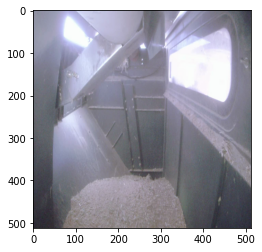

In [5]:
import matplotlib.pyplot as plt
plt.imshow(a)
plt.show()

In [1]:
import cv2

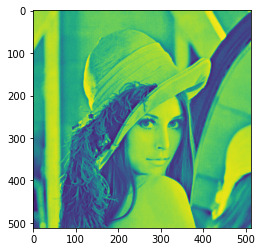

In [3]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import scipy.misc as scm
import matplotlib.pyplot as p

mod = SourceModule \
    (
        """

__global__ void standardize(float *dest_r, float *dest_g, float *dest_b, float *r_img, float *g_img, float *b_img)
{

unsigned int idx = threadIdx.x+(blockIdx.x*(blockDim.x*blockDim.y));

dest_r[idx] = ((r_img[idx]/255 - 0.485)) / 0.229;
dest_g[idx] = ((g_img[idx]/255 - 0.456)) / 0.224;
dest_b[idx] = ((b_img[idx]/255 - 0.406)) / 0.225;


}

""")
a = cv2.imread('./lena.png').astype(np.float32)
r_img = a[:, :, 0].reshape(262144, order='F')
g_img = a[:, :, 1].reshape(262144, order='F')
b_img = a[:, :, 2].reshape(262144, order='F')
dest_r=r_img
dest_g=g_img
dest_b=b_img
standardize = mod.get_function("standardize")
standardize(drv.Out(dest_r), drv.Out(dest_g), drv.Out(dest_b), drv.In(r_img), drv.In(g_img),drv.In(b_img),block=(1024, 1, 1), grid=(256, 1, 1))

dest_r=np.reshape(dest_r,(512,512), order='F')
dest_b=np.reshape(dest_b,(512,512), order='F')
p.imshow(dest_b)
p.show()

In [1]:
import numpy as np
import cv2

def standardize_cpu(image):
    rgb_means = [0.485, 0.456, 0.406]
    rgb_means_array = np.reshape(np.array(rgb_means), (1, 1, len(rgb_means)))

    rgb_stddevs = [0.229, 0.224, 0.225]
    rgb_stddevs_array = np.reshape(np.array(rgb_stddevs), (1, 1, len(rgb_stddevs)))

    image = image / 255.0
    image -= rgb_means_array
    image /= rgb_stddevs_array
    return image

import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

mod = SourceModule \
    (
        """                                                                                                                                                                              
                                                                                                                                                              
                                                                                                                                                                                         
__global__ void standardize(float *dest_r, float *dest_g, float *dest_b, float *r_img, float *g_img, float *b_img)                                                                       
{                                                                                                                                                                                        
                                                                                                                                                                                         
unsigned int idx = threadIdx.x+(blockIdx.x*(blockDim.x*blockDim.y));

dest_r[idx] = ((r_img[idx]/255 - 0.485)) / 0.229;
dest_g[idx] = ((g_img[idx]/255 - 0.456)) / 0.224;
dest_b[idx] = ((b_img[idx]/255 - 0.406)) / 0.225;                                                                                                                                                                                  
}                                                                                                                                                                                        
                                                                                                                                                                                         
""")
#a = np.random.randint(0, 256, (512, 512, 3), dtype=np.uint8)
a = np.load("/home/nvidia/resized.npy")
# r_img = a[:, :, 0].reshape(262144, order='F').astype(np.float32)
# g_img = a[:, :, 1].reshape(262144, order='F').astype(np.float32)
# b_img = a[:, :, 2].reshape(262144, order='F').astype(np.float32)
r_img = a[:, :, 0].reshape(262144).astype(np.float32)
g_img = a[:, :, 1].reshape(262144).astype(np.float32)
b_img = a[:, :, 2].reshape(262144).astype(np.float32)
dest_r=np.zeros_like(r_img).astype(np.float32)
dest_g=np.zeros_like(g_img).astype(np.float32)
dest_b=np.zeros_like(b_img).astype(np.float32)
standardize = mod.get_function("standardize")
standardize(drv.Out(dest_r), drv.Out(dest_g), drv.Out(dest_b), drv.In(r_img), drv.In(g_img),drv.In(b_img),block=(1024, 1, 1), grid=(256, 1, 1))

res_cpu = standardize_cpu(a)
# dest_r=np.reshape(dest_r,(512,512), order='F')
# print(np.allclose(dest_r, res_cpu[:,:,0]))
# dest_g=np.reshape(dest_g,(512,512), order='F')
# print(np.allclose(dest_g, res_cpu[:,:,1]))
# dest_b=np.reshape(dest_b,(512,512), order='F')
# print(np.allclose(dest_b, res_cpu[:,:,2]))

res_gpu_2 = np.concatenate((dest_r, dest_g, dest_b), axis=None)
res_cpu_2 = res_cpu.transpose((2, 0, 1)).ravel()
print(np.allclose(res_gpu_2, res_cpu_2))

True


In [5]:
import numpy as np
import cv2

def standardize_cpu(image):
    rgb_means = [0.485, 0.456, 0.406]
    rgb_means_array = np.reshape(np.array(rgb_means), (1, 1, len(rgb_means)))

    rgb_stddevs = [0.229, 0.224, 0.225]
    rgb_stddevs_array = np.reshape(np.array(rgb_stddevs), (1, 1, len(rgb_stddevs)))

    image = image / 255.0
    image -= rgb_means_array
    image /= rgb_stddevs_array
    return image

import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

mod = SourceModule \
    (
        """
__global__ void standardize(float *dest_r, float *dest_g, float *dest_b, float *r_img, float *g_img, float *b_img, int image_size)
{
    int total_thread_count = blockDim.x * gridDim.x;
    int global_thread_id = threadIdx.x+(blockIdx.x*(blockDim.x));
    for(int i = global_thread_id; i < image_size; i += total_thread_count)
    {
        dest_r[i] = ((r_img[i]/255 - 0.485)) / 0.229;
        dest_g[i] = ((g_img[i]/255 - 0.456)) / 0.224;
        dest_b[i] = ((b_img[i]/255 - 0.406)) / 0.225;
    }
}
""")
w = 512
h = 512

a = np.random.randint(0, 256, (h, w, 3), dtype=np.uint8)
#a = np.load("/home/nvidia/resized.npy")
# r_img = a[:, :, 0].reshape(262144, order='F').astype(np.float32)
# g_img = a[:, :, 1].reshape(262144, order='F').astype(np.float32)
# b_img = a[:, :, 2].reshape(262144, order='F').astype(np.float32)
r_img = a[:, :, 0].reshape(w * h).astype(np.float32)
g_img = a[:, :, 1].reshape(w * h).astype(np.float32)
b_img = a[:, :, 2].reshape(w * h).astype(np.float32)

r_img = np.ones(w * h).astype(np.float32)
g_img = np.ones(w * h).astype(np.float32) + 1
b_img = np.ones(w * h).astype(np.float32) + 2
a = np.stack([np.ones((w,h)), np.ones((w, h)) + 1, np.ones((w, h)) + 2], axis=2)

dest_r=np.zeros_like(r_img).astype(np.float32)
dest_g=np.zeros_like(g_img).astype(np.float32)
dest_b=np.zeros_like(b_img).astype(np.float32)

standardize = mod.get_function("standardize")
image_size = np.intc(w*h)
standardize(drv.Out(dest_r), drv.Out(dest_g), drv.Out(dest_b), drv.In(r_img), drv.In(g_img),drv.In(b_img), image_size,block=(1024, 1, 1), grid=(256, 1, 1))

res_cpu = standardize_cpu(a)
# dest_r=np.reshape(dest_r,(512,512), order='F')
# print(np.allclose(dest_r, res_cpu[:,:,0]))
# dest_g=np.reshape(dest_g,(512,512), order='F')
# print(np.allclose(dest_g, res_cpu[:,:,1]))
# dest_b=np.reshape(dest_b,(512,512), order='F')
# print(np.allclose(dest_b, res_cpu[:,:,2]))

res_gpu_2 = np.concatenate((dest_r, dest_g, dest_b), axis=None)
res_cpu_2 = res_cpu.transpose((2, 0, 1)).ravel()
print(np.allclose(res_gpu_2, res_cpu_2))

True


In [30]:
res_gpu_2

array([-2.100779 , -2.100779 , -2.100779 , ..., -1.7521569, -1.7521569,
       -1.7521569], dtype=float32)

In [65]:
res_cpu

array([-2.10077918, -2.10077918, -2.10077918, ..., -1.75215686,
       -1.75215686, -1.75215686])

In [17]:
dest_r

array([-1.6384108 , -1.9980307 , -0.23418099, ...,  0.51930827,
        0.7933043 , -0.9020463 ], dtype=float32)

In [19]:
res_cpu.shape

(100, 400, 3)

In [31]:
res_cpu

array([[[-0.06293347,  1.20308123,  0.75764706],
        [-1.68978508, -0.28501401,  1.35023965],
        [ 0.17681308,  1.25560224,  0.94936819],
        ...,
        [-0.08005822,  2.02591036,  2.0648366 ],
        [ 0.33093587,  0.32773109, -0.53211329],
        [ 0.10831407,  2.37605042,  1.43738562]],

       [[-0.69654936,  1.72829132, -1.08984749],
        [-0.55955133,  1.6407563 ,  1.24566449],
        [-0.88492165, -1.26540616, -0.84583878],
        ...,
        [ 1.95778748,  1.36064426,  2.11712418],
        [-0.43967805, -0.07492997,  0.44392157],
        [ 1.8379142 , -0.17997199,  1.62910675]],

       [[ 0.22818734, -1.84313725,  2.09969499],
        [ 2.21465879, -1.86064426, -0.34039216],
        [ 2.09478551,  0.94047619,  2.3611329 ],
        ...,
        [-1.7582841 ,  1.25560224,  2.58771242],
        [ 0.98167651,  1.99089636,  1.83825708],
        [-1.70690984, -1.00280112,  2.60514161]],

       ...,

       [[ 0.62205668,  0.17016807,  0.79250545],
        [-0

In [68]:
res_cpu[:,:,0]

array([[-2.10077918, -2.10077918, -2.10077918, ..., -2.10077918,
        -2.10077918, -2.10077918],
       [-2.10077918, -2.10077918, -2.10077918, ..., -2.10077918,
        -2.10077918, -2.10077918],
       [-2.10077918, -2.10077918, -2.10077918, ..., -2.10077918,
        -2.10077918, -2.10077918],
       ...,
       [-2.10077918, -2.10077918, -2.10077918, ..., -2.10077918,
        -2.10077918, -2.10077918],
       [-2.10077918, -2.10077918, -2.10077918, ..., -2.10077918,
        -2.10077918, -2.10077918],
       [-2.10077918, -2.10077918, -2.10077918, ..., -2.10077918,
        -2.10077918, -2.10077918]])

In [70]:
np.allclose(res_cpu[:,:,0], dest_r.reshape(res_cpu[:,:,0].shape))

True

In [76]:
np.allclose(res_cpu[:,:,1], dest_g.reshape(res_cpu[:,:,1].shape))

False

In [81]:
res_cpu[:,:,1]

array([[-2.00070028, -2.00070028, -2.00070028, ..., -2.00070028,
        -2.00070028, -2.00070028],
       [-2.00070028, -2.00070028, -2.00070028, ..., -2.00070028,
        -2.00070028, -2.00070028],
       [-2.00070028, -2.00070028, -2.00070028, ..., -2.00070028,
        -2.00070028, -2.00070028],
       ...,
       [-2.00070028, -2.00070028, -2.00070028, ..., -2.00070028,
        -2.00070028, -2.00070028],
       [-2.00070028, -2.00070028, -2.00070028, ..., -2.00070028,
        -2.00070028, -2.00070028],
       [-2.00070028, -2.00070028, -2.00070028, ..., -2.00070028,
        -2.00070028, -2.00070028]])

In [82]:
dest_g.reshape(res_cpu[:,:,2].shape)

array([[-2.0836544, -2.0836544, -2.0836544, ..., -2.0836544, -2.0836544,
        -2.0836544],
       [-2.0836544, -2.0836544, -2.0836544, ..., -2.0836544, -2.0836544,
        -2.0836544],
       [-2.0836544, -2.0836544, -2.0836544, ..., -2.0836544, -2.0836544,
        -2.0836544],
       ...,
       [-2.0836544, -2.0836544, -2.0836544, ..., -2.0836544, -2.0836544,
        -2.0836544],
       [-2.0836544, -2.0836544, -2.0836544, ..., -2.0836544, -2.0836544,
        -2.0836544],
       [-2.0836544, -2.0836544, -2.0836544, ..., -2.0836544, -2.0836544,
        -2.0836544]], dtype=float32)

In [34]:
x.shape

(786432,)

In [35]:
r_img.shape

(262144,)

In [58]:
x = np.stack([np.ones((w,h)), np.ones((w, h)) + 1, np.ones((w, h)) + 2], axis=2)

In [59]:
x.shape

(512, 512, 3)

In [48]:
a = np.ones((w, h)) + 1

In [49]:
b = np.ones((w, h)) + 2

In [50]:
c = np.ones((w, h))

In [52]:
x = np.concatenate(a, b, c)

TypeError: only integer scalar arrays can be converted to a scalar index

In [53]:
a.shape

(512, 512)